<a href="https://colab.research.google.com/github/plaban1981/DL_guided_Project/blob/main/MNIST_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

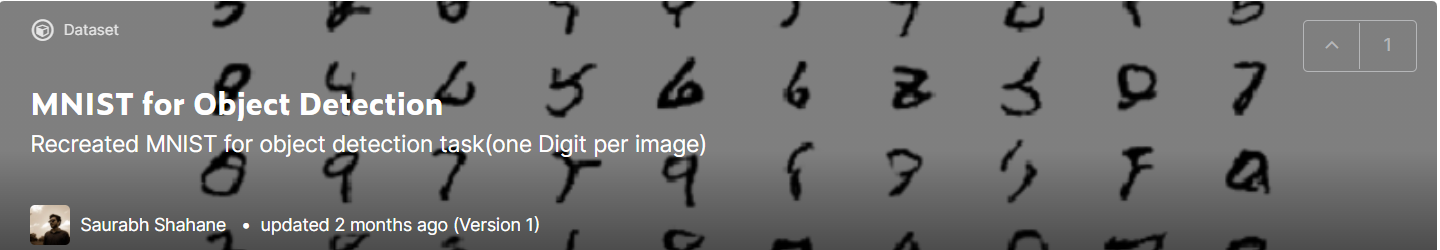

https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

https://colab.research.google.com/github/AlaaSenjab/-Tutorial-Tensorflow_Object_Detection_API_On_Custom_Dataset/blob/master/weapon_detection_BL.ipynb#scrollTo=xMckMSJqFMyc

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

##Download data from kaggle to colab

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"plabannayak","key":"f1f19a1783935d871fc0049a716ef3a8"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d saurabhshahane/mnist-for-object-detection

 51% 9.00M/17.8M [00:00<00:00, 51.0MB/s]
100% 17.8M/17.8M [00:00<00:00, 80.9MB/s]


## Unzip data and save in google drive

In [ ]:
!unzip "/content/mnist-for-object-detection.zip" -d "/content/drive/MyDrive/Object_detection"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Object_detection/mnist_detection/train/labels/5499.txt  
  inflating: /content/drive/MyDrive/Object_detection/mnist_detection/train/labels/55.txt  
  inflating: /content/drive/MyDrive/Object_detection/mnist_detection/train/labels/550.txt  
  inflating: /content/drive/MyDrive/Object_detection/mnist_detection/train/labels/5500.txt  
  inflating: /content/drive/MyDrive/Object_detection/mnist_detection/train/labels/5501.txt  
  inflating: /content/drive/MyDrive/Object_detection/mnist_detection/train/labels/5502.txt  
  inflating: /content/drive/MyDrive/Object_detection/mnist_detection/train/labels/5503.txt  
  inflating: /content/drive/MyDrive/Object_detection/mnist_detection/train/labels/5504.txt  
  inflating: /content/drive/MyDrive/Object_detection/mnist_detection/train/labels/5505.txt  
  inflating: /content/drive/MyDrive/Object_detection/mnist_detection/train/labels/5506.txt  
  inflating: /content/

## Importing and Installing Required Packages.

In [ ]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -qq Cython contextlib2 pillow lxml matplotlib

!pip install -qq pycocotools

Selecting previously unselected package python-bs4.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

## General Imports

In [ ]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv
import re
import cv2 
import os
import glob
import xml.etree.ElementTree as ET

import io
import tensorflow.compat.v1 as tf

from PIL import Image
from collections import namedtuple, OrderedDict

import shutil
import urllib.request
import tarfile

## How to Prepare a Dataset for Object Detection

In [ ]:
with open("/content/drive/MyDrive/Object_detection/mnist_detection/train/labels/0.txt",'r') as f:
  print(f.readlines())

['label,xmin,ymin,xmax,ymax\n', '6,270,261,283,280\n']


In [ ]:
import glob

path = "/content/drive/MyDrive/Object_detection/mnist_detection/train/labels"
all_files = glob.glob(path + "/*.txt")

li = []

for filename in all_files:
    df = pd.read_csv(filename,delimiter=",")
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
frame.head()

,label,xmin,ymin,xmax,ymax
0,6,270,261,283,280
1,2,61,241,80,260
2,1,148,190,165,239
3,6,200,174,245,237
4,1,93,271,101,289


In [ ]:
frame.shape

(10000, 5)

* The size and the bounding boxes are the minimum information that we require from each annotation /label file

## Train DataFrame

In [ ]:
train_path = "/content/drive/MyDrive/Object_detection/mnist_detection/train/images"
train_images = [img for img in os.listdir(train_path)]
train = pd.DataFrame({'Filename':train_images})
train.head()


,Filename
0,0.png
1,1.png
2,10.png
3,100.png
4,1000.png


In [ ]:
df_train = pd.concat([train,frame],axis=1)
df_train.head()

,Filename,label,xmin,ymin,xmax,ymax
0,0.png,6,270,261,283,280
1,1.png,2,61,241,80,260
2,10.png,1,148,190,165,239
3,100.png,6,200,174,245,237
4,1000.png,1,93,271,101,289


In [ ]:
df_train.to_csv("/content/drive/MyDrive/Object_detection/mnist_detection/training.csv",index=False)

## Testing Dataframe

In [ ]:
test_path = "/content/drive/MyDrive/Object_detection/mnist_detection/test/images"
test_images = [img for img in os.listdir(test_path)]
test = pd.DataFrame({'Filename':test_images})
test.head()

,Filename
0,0.png
1,1.png
2,10.png
3,100.png
4,101.png


In [ ]:
path = "/content/drive/MyDrive/Object_detection/mnist_detection/test/labels"
all_files = glob.glob(path + "/*.txt")

li = []

for filename in all_files:
    df = pd.read_csv(filename,delimiter=",")
    li.append(df)

frame_test = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
frame_test.head()

,label,xmin,ymin,xmax,ymax
0,6,124,107,157,160
1,3,203,63,247,117
2,8,134,176,192,243
3,8,5,168,25,188
4,0,135,122,186,179


In [ ]:
df_test = pd.concat([test,frame_test],axis=1)
df_test.head()

,Filename,label,xmin,ymin,xmax,ymax
0,0.png,6,124,107,157,160
1,1.png,3,203,63,247,117
2,10.png,8,134,176,192,243
3,100.png,8,5,168,25,188
4,101.png,0,135,122,186,179


In [ ]:
df_test.to_csv("/content/drive/MyDrive/Object_detection/mnist_detection/testing.csv",index=False)

In [ ]:
%cd /content/drive/MyDrive/Object_detection/mnist_detection/models/research
#compiling the proto buffers (not important to understand for this project but you can learn more about them here: https://developers.google.com/protocol-buffers/)
!protoc object_detection/protos/*.proto --python_out=.

# exports the PYTHONPATH environment variable with the reasearch and slim folders' paths
os.environ['PYTHONPATH'] += ':/content/drive/MyDrive/Object_detection/mnist_detection/models/research/:/content/drive/MyDrive/Object_detection/mnist_detection/models/research/slim/'

/content/drive/MyDrive/Object_detection/mnist_detection/models/research
object_detection/protos/*.proto: No such file or directory


In [ ]:
%cd /content/drive/MyDrive/Object_detection
!git clone --q https://github.com/tensorflow/models.git

/content/drive/MyDrive/Object_detection


In [ ]:
%cd /content/drive/MyDrive/Object_detection/models/research
#compiling the proto buffers (not important to understand for this project but you can learn more about them here: https://developers.google.com/protocol-buffers/)
!protoc object_detection/protos/*.proto --python_out=.

# exports the PYTHONPATH environment variable with the reasearch and slim folders' paths
os.environ['PYTHONPATH'] += ':/content/gun_detection/models/research/:/content/gun_detection/models/research/slim/'

/content/drive/MyDrive/Object_detection/models/research


In [ ]:
# testing the model builder
%cd /content/drive/MyDrive/Object_detection/models/research/object_detection/builders
!python3 model_builder_test.py

/content/drive/MyDrive/Object_detection/models/research/object_detection/builders
Traceback (most recent call last):
  File "model_builder_test.py", line 21, in <module>
    from object_detection.builders import model_builder
ModuleNotFoundError: No module named 'object_detection'
